# RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [190]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [191]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [192]:
df.columns = ['Sales']

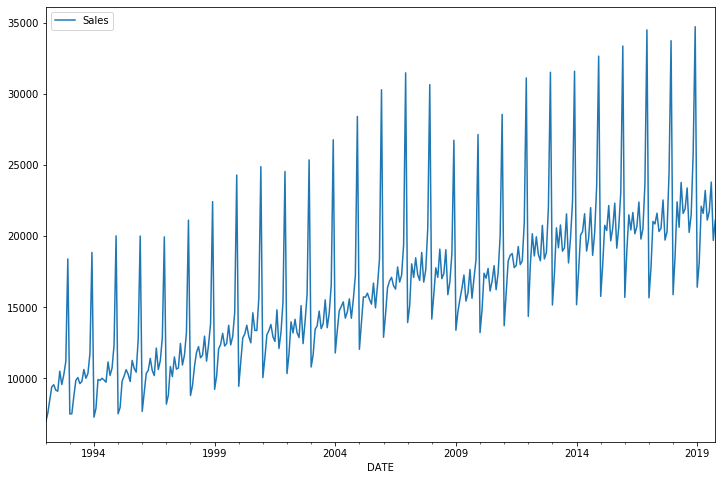

In [193]:
df.plot(figsize=(12,8))

## Train Test Split

In [194]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [195]:
len(df)- 18

316

In [196]:
test_size = 18

In [197]:
test_ind = len(df)- test_size

In [198]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [199]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [200]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [201]:
from sklearn.preprocessing import MinMaxScaler

In [202]:
scaler = MinMaxScaler()

In [203]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [204]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [205]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [468]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, stride=1, batch_size=1)

In [469]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, stride=1, batch_size=1)

In [470]:
# What does the first batch look like?
X,y = generator[0]

In [471]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [528]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, SimpleRNN, LSTM, GRU, concatenate, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [529]:
# We're only using one feature in our time series
n_features = 1

In [530]:
# define model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = [tf.keras.metrics.MeanAbsolutePercentageError()])

In [270]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, min_lr=1e-7, verbose = 1, patience=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=2)
mc = ModelCheckpoint('rnn_best_model.h5', monitor='val_loss', mode='min', verbose = 1, save_best_only=True)

In [498]:
def build_model(lr = 0, dr = 0):
    model = Sequential()
    model.add(LSTM(128, input_shape=(length, n_features), activation='relu', return_sequences=True)) 
    model.add(Dropout(dr))
    model.add(LSTM(128))
    model.add(Dense(1, activation = 'linear'))
    
    opt = tf.keras.optimizers.Adam(lr = lr)
    model.compile(loss = "mse", optimizer = opt, metrics = [tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [514]:
def build_model(lr = 0, dr = 0):
    model = Sequential()
    model.add(Bidirectional(GRU(128, input_shape=(length, n_features), activation='relu', return_sequences=True)))
    model.add(Dropout(dr))
    model.add(Bidirectional(GRU(128)))
    model.add(Dense(1, activation = 'linear'))
    
    opt = tf.keras.optimizers.Adam(lr = lr)
    model.compile(loss = "mse", optimizer = opt, metrics = [tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [515]:
model = build_model(lr = 0.001, dr = 0)

In [531]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               16640     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 129       
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [532]:
# fit model
model.fit_generator(generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[rlr, es, mc])

Epoch 1/20
303/304 [============================>.] - ETA: 0s - loss: 0.0189 - mean_absolute_percentage_error: 51.2479
Epoch 00001: val_loss did not improve from 0.00024
304/304 [==============================] - 11s 38ms/step - loss: 0.0188 - mean_absolute_percentage_error: 51.1090 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 9.8124
Epoch 2/20
303/304 [============================>.] - ETA: 0s - loss: 0.0047 - mean_absolute_percentage_error: 27.6208
Epoch 00002: val_loss did not improve from 0.00024
304/304 [==============================] - 12s 41ms/step - loss: 0.0047 - mean_absolute_percentage_error: 27.5389 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 6.7403
Epoch 3/20
302/304 [============================>.] - ETA: 0s - loss: 0.0018 - mean_absolute_percentage_error: 16.5683
Epoch 00003: val_loss did not improve from 0.00024
304/304 [==============================] - 12s 39ms/step - loss: 0.0018 - mean_absolute_percentage_error: 16.5262 - val_loss: 0.0012 -

In [533]:
losses = pd.DataFrame(model.history.history)

In [534]:
losses

,loss,mean_absolute_percentage_error,val_loss,val_mean_absolute_percentage_error,lr
0,0.018806,51.108974,0.004700,9.812428,0.001000
1,0.004659,27.538935,0.002191,6.740270,0.001000
2,0.001810,16.526220,0.001200,5.588583,0.001000
3,0.001466,16.203527,0.001092,5.462849,0.001000
4,0.001347,12.200676,0.003091,10.066787,0.001000
5,0.000662,10.801511,0.000432,3.212917,0.000050
6,0.000431,8.771500,0.000528,3.440372,0.000050
7,0.000385,8.079206,0.000512,3.431134,0.000003


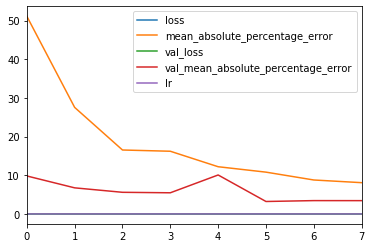

In [535]:
losses.plot()

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [536]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [537]:
true_predictions = scaler.inverse_transform(test_predictions)

In [538]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

c:\users\jie.hu\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [539]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
# load the saved model
#from tensorflow.keras.models import load_model
#saved_best_model = load_model('best_model.h5')

# RMSE
np.sqrt(mean_squared_error(test['Sales'], test['Predictions']))

1142.0101483903254

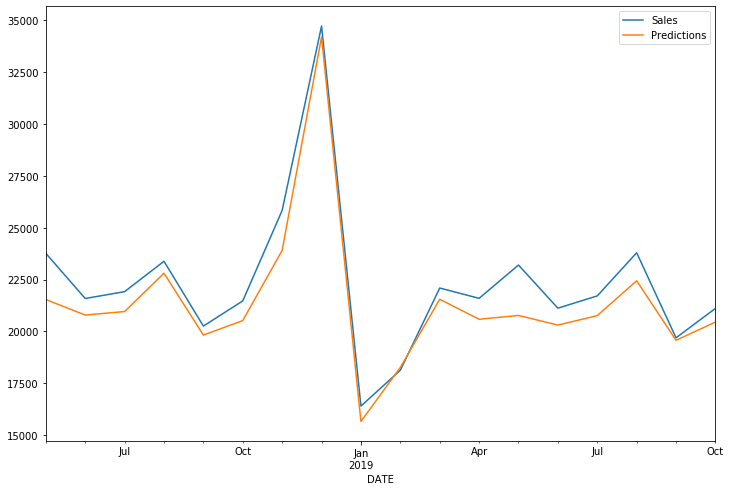

In [540]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [40]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [41]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [43]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=6)

Epoch 1/6
322/322 [==============================] - 12s 37ms/step - loss: 0.0228
Epoch 2/6
322/322 [==============================] - 12s 38ms/step - loss: 0.0132
Epoch 3/6
322/322 [==============================] - 13s 41ms/step - loss: 0.0061
Epoch 4/6
322/322 [==============================] - 13s 39ms/step - loss: 0.0035
Epoch 5/6
322/322 [==============================] - 16s 49ms/step - loss: 0.0021
Epoch 6/6
322/322 [==============================] - 15s 48ms/step - loss: 0.0015


In [44]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [45]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [46]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [47]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [48]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [49]:
forecast_df

,Forecast
2019-11-01,26592.941439
2019-12-01,39696.054592
2020-01-01,16652.277780
2020-02-01,18289.230921
2020-03-01,22087.817626
2020-04-01,21818.583705
2020-05-01,23598.882994
2020-06-01,21584.729504
2020-07-01,22236.471552
2020-08-01,24408.636945


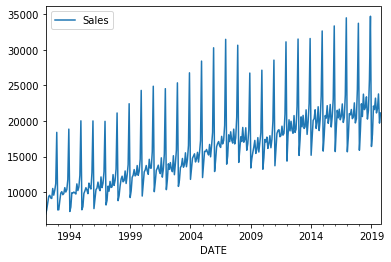

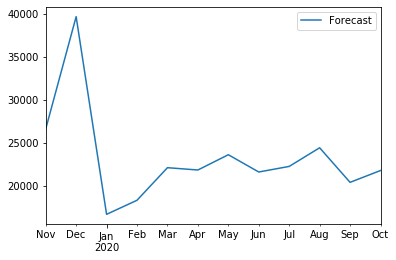

In [50]:
df.plot()
forecast_df.plot()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

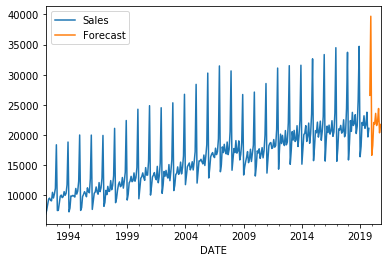

In [51]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 611)

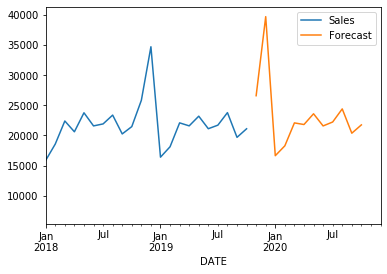

In [52]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')